# 1. importing libraries

In [1]:
import math
import datetime
import warnings
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from ipywidgets import HBox, VBox
from tabulate import tabulate
from xgboost import plot_importance, plot_tree
from numpy.polynomial.polynomial import Polynomial
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score,mean_absolute_percentage_error
#Matplotlib style
plt.style.use('fivethirtyeight')
#Ignoring some warnings
warnings.filterwarnings('ignore')

# 2. reading data & preprocessing

In [2]:
# 读取数据
hs300_stock_raw_data = pd.read_csv("rv_5min/zdata/ff000300.csv")
# 计算对数收益率并乘以100
returns_hs300 = 100 * np.log(hs300_stock_raw_data['close'] / hs300_stock_raw_data['close'].shift(1))
# 删除缺失值和第一个NaN
returns_hs300 = returns_hs300.dropna()

In [3]:
#Using the raw close prices to plot the evolution of the stock
close_prices = pd.DataFrame(hs300_stock_raw_data["close"])
#By dividing each close price by the first price in our dataset we calculate the accumulated return for each day
cum_rets = close_prices / close_prices.iloc[0,:]
#Using the plotly.express module we can plot our newly created cum_rets
fig = px.line(cum_rets.iloc[:,:], width=1000, height=500)
#Adding Title
fig.update_layout(title_text='Cumulative Return of hs300 from 2010-01-04 to 2023-10-31')
#This will print the graph
fig.show()

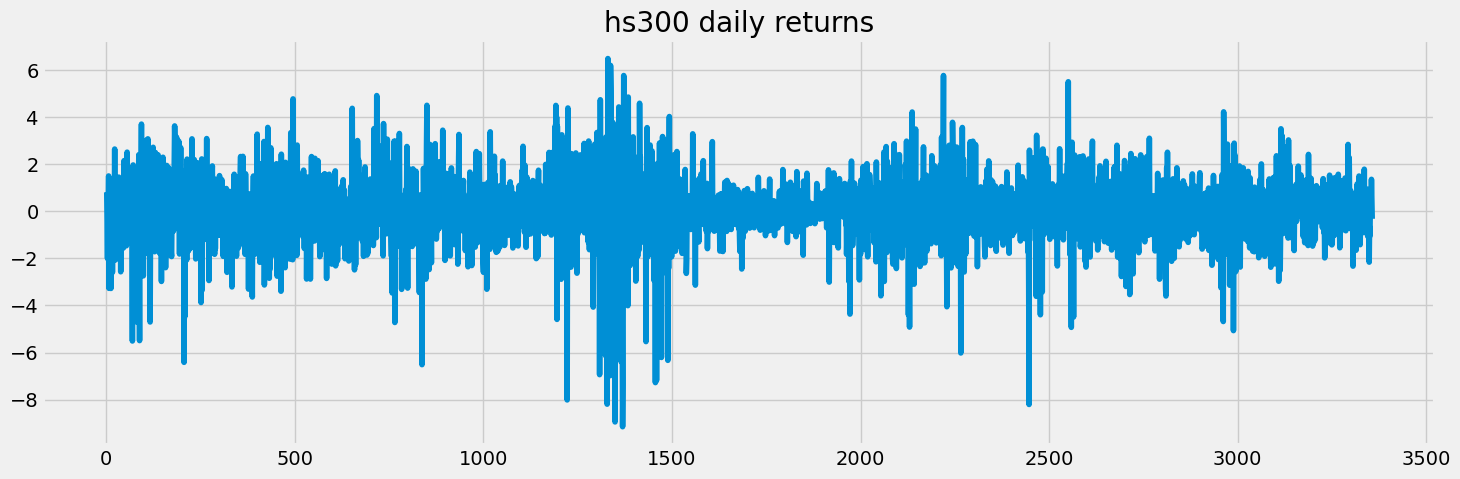

In [4]:
#We can plot the daily retuns of hs300 using a line graph using .plot from pandas
returns_hs300.plot(figsize =(16,5), title = 'hs300 daily returns');

In [5]:
hs300_stock_raw_data = pd.read_csv("rv_5min/zdata/ff000300.csv")
df = hs300_stock_raw_data.copy()
df = hs300_stock_raw_data[['date', 'close','amplitude','flucamount','turnoverrate','volume']]
# 加一个copy不影响原表
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.close.pct_change().dropna()
# 计算对数收益率
df['log_returns'] = np.log(df.close/df.close.shift(1))
# 删除缺失值和第一个NaN
df['log_returns'] = df['log_returns'].dropna()
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

df.head(5)

,date,close,amplitude,flucamount,turnoverrate,volume,returns,log_returns
1,2010-01-05,3564.04,2.26,28.81,0.28,85809641,0.814940,0.008116
2,2010-01-06,3541.73,1.34,-22.31,0.26,78473125,-0.625975,-0.006279
3,2010-01-07,3471.46,2.99,-70.27,0.26,80350037,-1.984059,-0.020040
4,2010-01-08,3480.13,1.60,8.67,0.20,60790253,0.249751,0.002494
5,2010-01-11,3482.05,3.71,1.92,0.29,89980172,0.055170,0.000552


In [6]:
# 将 "Date" 列转换为日期格式
df['date'] = pd.to_datetime(df['date'])
# 显示转换后的 DataFrame
df.head()

,date,close,amplitude,flucamount,turnoverrate,volume,returns,log_returns
1,2010-01-05,3564.04,2.26,28.81,0.28,85809641,0.814940,0.008116
2,2010-01-06,3541.73,1.34,-22.31,0.26,78473125,-0.625975,-0.006279
3,2010-01-07,3471.46,2.99,-70.27,0.26,80350037,-1.984059,-0.020040
4,2010-01-08,3480.13,1.60,8.67,0.20,60790253,0.249751,0.002494
5,2010-01-11,3482.05,3.71,1.92,0.29,89980172,0.055170,0.000552


In [7]:
#INTERVAL_WINDOW = 22
#n_future = 1
# GET BACKWARD LOOKING REALIZED VOLATILITY
#df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   #.apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
#df['vol_future'] = df.log_returns.shift(-n_future)\
                                 #.rolling(window=INTERVAL_WINDOW)\
                                 #.apply(realized_volatility_daily)

In [8]:
rv_5 = pd.read_csv('rv_5min/zdata/rv__5min.csv')
df['rv'] = rv_5['RV'].iloc[1:]
df['rv2'] = rv_5['RV'].iloc[1:].shift(1)
df['rv_future'] = rv_5['RV'].shift(-1)
df['rv_w'] = rv_5['RV_weekly'].iloc[1:]
df['rv_m'] = rv_5['RV_monthly'].iloc[1:]

df.tail()

,date,close,amplitude,flucamount,turnoverrate,volume,returns,log_returns,rv,rv2,rv_future,rv_w,rv_m
3353,2023-10-25,3504.46,0.89,17.33,0.42,128009617,0.496970,0.004957,0.004164,0.009113,0.004087,0.006271,0.004107
3354,2023-10-26,3514.14,1.07,9.68,0.34,105143566,0.276219,0.002758,0.004087,0.004164,0.007263,0.005853,0.004083
3355,2023-10-27,3562.39,2.33,48.25,0.39,120225108,1.373024,0.013637,0.007263,0.004087,0.004421,0.006077,0.004236
3356,2023-10-30,3583.77,1.09,21.38,0.47,144010426,0.600159,0.005984,0.004421,0.007263,0.003253,0.005810,0.004353
3357,2023-10-31,3572.51,0.76,-11.26,0.37,112587267,-0.314194,-0.003147,0.003253,0.004421,0.002720,0.004638,0.004363


In [9]:
#Convert the date column to datetime format
df["date"] = pd.to_datetime(df["date"])
df.index = df['date']
#Rename the dataframe
serie = df.copy()

#Split train and test

# 假设 'serie' 是一个 Pandas Series 对象
total_length = len(serie)

# 确定训练集、验证集和测试集的分界点
split1 = int(0.8 * total_length)  # 80% 用于训练集
#split2 = int(0.8 * total_length)  # 20% 用于验证集

# 划分数据集
train_ = serie[:split1].dropna()
vali_ = serie[split1:].dropna()
#test_ = serie_clean[split2:]

print("训练集大小:", train_.index)
print("验证集大小:", vali_.index)
#print("测试集大小:", test_.index)

# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = train_['rv_future']
y_vali = vali_['rv_future']
#y_test = test_['rv_future']


# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = train_[['rv','rv_w','rv_m']]
x_vali = vali_[['rv','rv_w','rv_m']]
#x_test = test_[['rv','rv_w','rv_m']]


训练集大小: DatetimeIndex(['2010-02-02', '2010-02-03', '2010-02-04', '2010-02-05',
               '2010-02-08', '2010-02-09', '2010-02-10', '2010-02-11',
               '2010-02-12', '2010-02-22',
               ...
               '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-11',
               '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15',
               '2021-01-18', '2021-01-19'],
              dtype='datetime64[ns]', name='date', length=2665, freq=None)
验证集大小: DatetimeIndex(['2021-01-20', '2021-01-21', '2021-01-22', '2021-01-25',
               '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29',
               '2021-02-01', '2021-02-02',
               ...
               '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-23',
               '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27',
               '2023-10-30', '2023-10-31'],
              dtype='datetime64[ns]', name='date', length=672, freq=None)


# 2. import ti (& ta)

In [10]:
ti = pd.read_csv('rv_5min/zdata/ff000300.csv')
ti = ti.iloc[1:]
ti.index = df.index
rsi = pd.Series(ti['RSI'], index = ti.index)
m12 = pd.Series(ti['M12'], index = ti.index)
upperband = pd.Series(ti['Upper_band'], index = ti.index)
lowerband = pd.Series(ti['Lower_Band'], index = ti.index)
sma = pd.Series(ti['SMA'], index = ti.index)
sd = pd.Series(ti['SD'], index = ti.index)
atr = pd.Series(ti['ATR'], index = ti.index)

# 3. HAR

In [11]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(df["rv"].values)[1])
print("p-value for weekly RV:",adf(df["rv_w"].dropna().values)[1])
print("p-value for monthly RV:",adf(df["rv_m"].dropna().values)[1])

p-value for daily RV: 2.5767898895322938e-09
p-value for weekly RV: 3.8269094182272965e-05
p-value for monthly RV: 0.00031530232868713144


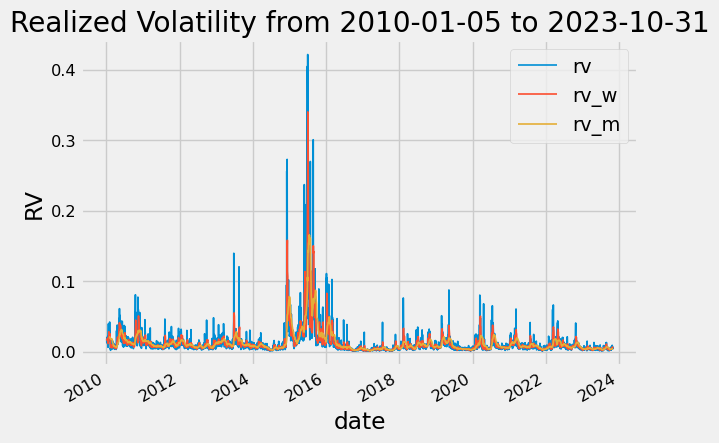

In [12]:
# Plot the RV variables.
df[['rv','rv_w','rv_m']].plot(title=f"Realized Volatility from {df.index.date[0]} to {df.index.date[-1]}", fontsize='small', linewidth=1.2)
plt.ylabel("RV")
plt.show()

In [13]:
x_train = sm.add_constant(x_train)
ols = sm.OLS(y_train, x_train)
ols_result = ols.fit(fit_intercept = True)
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:              rv_future   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     1032.
Date:                Mon, 23 Sep 2024   Prob (F-statistic):               0.00
Time:                        21:26:24   Log-Likelihood:                 7001.3
No. Observations:                2665   AIC:                        -1.399e+04
Df Residuals:                    2661   BIC:                        -1.397e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.573      0.0

In [14]:
x_vali = sm.add_constant(x_vali)
y_hat = ols_result.predict(x_vali)
y_hat

date
2021-01-20    0.012262
2021-01-21    0.011597
2021-01-22    0.010040
2021-01-25    0.012319
2021-01-26    0.010520
                ...   
2023-10-25    0.006239
2023-10-26    0.006012
2023-10-27    0.007107
2023-10-30    0.006122
2023-10-31    0.005204
Length: 672, dtype: float64

In [15]:
har = ols_result.predict(x_train)
har

date
2010-02-02    0.019265
2010-02-03    0.028610
2010-02-04    0.019892
2010-02-05    0.021523
2010-02-08    0.018064
                ...   
2021-01-13    0.015674
2021-01-14    0.016748
2021-01-15    0.020131
2021-01-18    0.013352
2021-01-19    0.014165
Length: 2665, dtype: float64

# 4. XGB

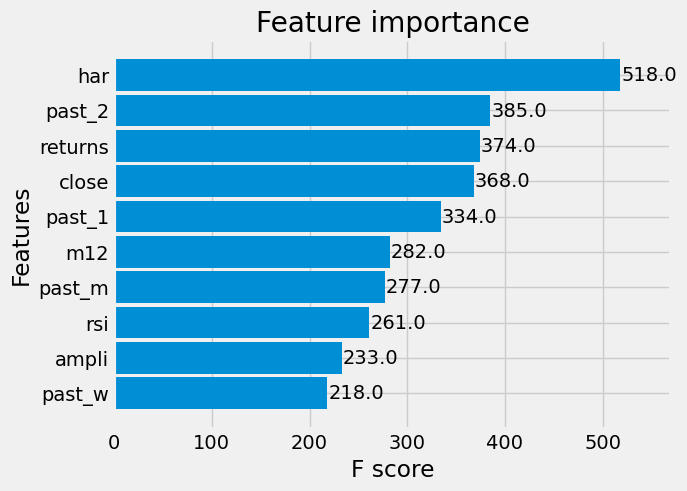

In [16]:
x_xgb = pd.DataFrame()  
y_xgb = y_train.copy()

x_xgb['har'] = har
x_xgb['past_1'] = df['rv'][:split1]
x_xgb['past_2'] = df['rv2'][:split1]
x_xgb['past_w'] = df['rv_w'][:split1]
x_xgb['past_m'] = df['rv_m'][:split1]
x_xgb['close'] = df['close'][:split1]
x_xgb['returns'] = df['returns'][:split1]
#x_xgb['turn'] = df['turnoverrate'][:split1]
#x_xgb['flucamount'] = df['flucamount'][:split1]
x_xgb['ampli'] = df['amplitude'][:split1]
x_xgb['rsi'] = rsi[:split1]
x_xgb['m12'] = m12[:split1]
#x_xgb['uperband'] = upperband[:split1]
#x_xgb['lowerband'] = lowerband[:split1]
#x_xgb['sma'] = sma[:split1]
#x_xgb['sd'] = sd[:split1]
#x_xgb['atr'] = atr[:split1]

# x_xgb = x_xgb.drop(rang(21))
x_xgb = pd.DataFrame(x_xgb, index = y_train.index)

from xgboost import XGBRegressor
xgb_har_ti_ta = XGBRegressor()
xgb_har_ti_ta.fit(x_xgb,y_xgb)
_ = plot_importance(xgb_har_ti_ta, height=0.9)

x_xgb2 = pd.DataFrame()  
y_xgb2 = y_vali.copy()

x_xgb2['har'] = y_hat
x_xgb2['past_1'] = df['rv'][split1:]
x_xgb2['past_2'] = df['rv2'][split1:]
x_xgb2['past_w'] = df['rv_w'][split1:]
x_xgb2['past_m'] = df['rv_m'][split1:]
x_xgb2['close'] = df['close'][split1:]
x_xgb2['returns'] = df['returns'][split1:]
#x_xgb2['turn'] = df['turnoverrate'][split1:]
#x_xgb2['flucamount'] = df['flucamount'][split1:]
x_xgb2['ampli'] = df['amplitude'][split1:]
x_xgb2['rsi'] = rsi[split1:]
x_xgb2['m12'] = m12[split1:]
#x_xgb2['uperband'] = upperband[split1:]
#x_xgb2['lowerband'] = lowerband[split1:]
#x_xgb2['sma'] = sma[split1:]
#x_xgb2['sd'] = sd[split1:]
#x_xgb2['atr'] = atr[split1:]

x_xgb2 = pd.DataFrame(x_xgb2, index = y_vali.index)

xgb_vali = xgb_har_ti_ta.predict(x_xgb2)
xgb_vali = pd.Series(xgb_vali, index = y_vali.index)

In [ ]:
'''
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# 定义目标函数，用于贝叶斯优化
def xgb_evaluate(max_depth, subsample, learning_rate,reg_lambda,alpha):
    # 这里假设xgb_model是已经定义好的XGBRegressor模型
    xgb_model = XGBRegressor(max_depth=int(max_depth),
                             learning_rate=learning_rate,
                             subsample=subsample,
                             random_state=42,
                             alpha = alpha,
                             reg_lambda = reg_lambda) 
    # 假设X_train, y_train是你的训练数据和标签
    xgb_model.fit(x_xgb, y_train)
    # 这里使用交叉验证评估模型性能，返回负的RMSE作为优化目标
    xgb_vali = xgb_model.predict(x_xgb2)
    score = -np.sqrt(mean_squared_error(xgb_vali, y_vali))
    return score

# 定义超参数搜索空间
pbounds = {
    'max_depth': (6, 12),  # 树的最大深度
    'learning_rate': (0.05, 0.09),  # 学习率
    'subsample': (0.7, 1),  # 训练时用到的样本比例
    'reg_lambda':(5,10),
    'alpha':(0,0.1)
}

# 初始化贝叶斯优化
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=1,
    verbose=2  # 打印详细过程
)

# 运行优化
optimizer.maximize(init_points=110, n_iter=110)
best_params = optimizer.max
best_params = best_params['params']
best_params['max_depth'] = int(round(best_params['max_depth']))
# 输出最优参数
print("最优的超参数: ", best_params)
'''

|   iter    |  target   |   alpha   | learni... | max_depth | reg_la... | subsample |
-------------------------------------------------------------------------------------
| 1         | -0.005068 | 0.0417    | 0.07881   | 6.001     | 6.512     | 0.744     |
| 2         | -0.005308 | 0.009234  | 0.05745   | 8.073     | 6.984     | 0.8616    |
| 3         | -0.005012 | 0.04192   | 0.07741   | 7.227     | 9.391     | 0.7082    |
| 4         | -0.005085 | 0.06705   | 0.06669   | 9.352     | 5.702     | 0.7594    |
| 5         | -0.005011 | 0.08007   | 0.08873   | 7.881     | 8.462     | 0.9629    |
| 6         | -0.005871 | 0.08946   | 0.0534    | 6.234     | 5.849     | 0.9634    |
| 7         | -0.005146 | 0.009835  | 0.06684   | 11.75     | 7.666     | 0.9076    |
| 8         | -0.005074 | 0.03155   | 0.07746   | 11.01     | 5.091     | 0.925     |
| 9         | -0.00492  | 0.09889   | 0.07993   | 7.683     | 8.946     | 0.731     |
| 10        | -0.004969 | 0.04479   | 0.08634   | 7.76

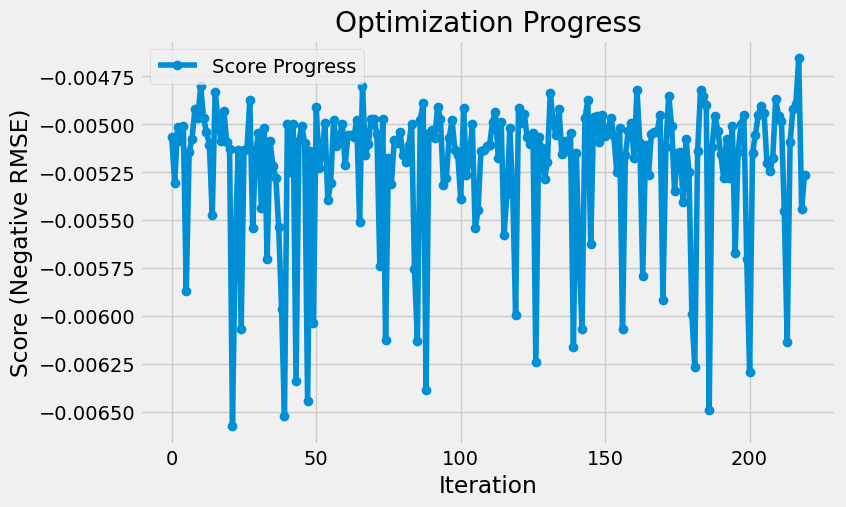

最优的超参数:  {'alpha': 0.0, 'learning_rate': 0.09, 'max_depth': 6, 'reg_lambda': 5.621357883348278, 'subsample': 0.7}


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 假设x_xgb, y_train, x_xgb2, y_vali是你的数据

# 定义目标函数，用于贝叶斯优化
def xgb_evaluate(max_depth, subsample, learning_rate, reg_lambda, alpha):
    xgb_model = XGBRegressor(max_depth=int(max_depth),
                             learning_rate=learning_rate,
                             subsample=subsample,
                             random_state=42,
                             alpha=alpha,
                             reg_lambda=reg_lambda)
    xgb_model.fit(x_xgb, y_train)
    xgb_vali = xgb_model.predict(x_xgb2)
    score = -np.sqrt(mean_squared_error(xgb_vali, y_vali))
    return score

# 定义超参数搜索空间
pbounds = {
    'max_depth': (6, 12),
    'learning_rate': (0.05, 0.09),
    'subsample': (0.7, 1),
    'reg_lambda': (5, 10),
    'alpha': (0, 0.1)
}

# 初始化贝叶斯优化
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

# 运行优化
optimizer.maximize(init_points=110, n_iter=110)  # 这里使用较少的迭代次数以便示例
best_params = optimizer.max['params']
best_params['max_depth'] = int(round(best_params['max_depth']))

# 收集优化过程中的每一步的分数
all_scores = [res['target'] for res in optimizer.res]

# 可视化损失函数随迭代次数的变化
plt.figure(figsize=(8, 5))
plt.plot(all_scores, '-o', label='Score Progress',lw = 0.5)
plt.title('Optimization Progress')
plt.xlabel('Iteration')
plt.ylabel('Score (Negative RMSE)')
plt.legend()
plt.show()

# 输出最优参数
print("最优的超参数: ", best_params)

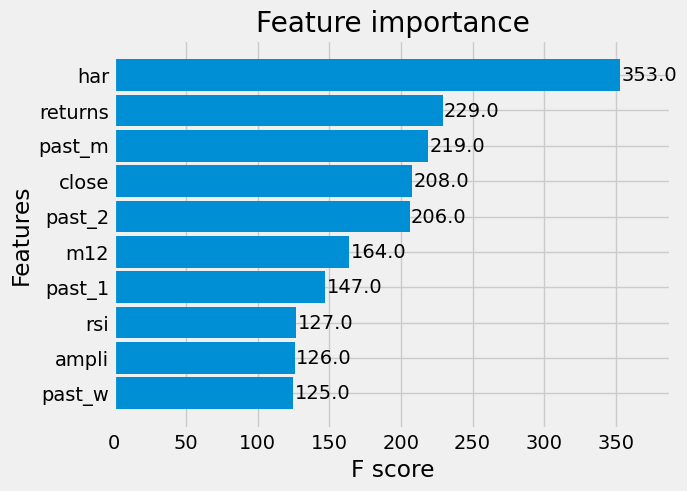

In [18]:
x_xgb = pd.DataFrame()  
y_xgb = y_train.copy()

x_xgb['har'] = har
x_xgb['past_1'] = df['rv'][:split1]
x_xgb['past_2'] = df['rv2'][:split1]
x_xgb['past_w'] = df['rv_w'][:split1]
x_xgb['past_m'] = df['rv_m'][:split1]
x_xgb['close'] = df['close'][:split1]
x_xgb['returns'] = df['returns'][:split1]
#x_xgb['turn'] = df['turnoverrate'][:split1]
#x_xgb['flucamount'] = df['flucamount'][:split1]
x_xgb['ampli'] = df['amplitude'][:split1]
x_xgb['rsi'] = rsi[:split1]
x_xgb['m12'] = m12[:split1]
#x_xgb['uperband'] = upperband[:split1]
#x_xgb['lowerband'] = lowerband[:split1]
#x_xgb['sma'] = sma[:split1]
#x_xgb['sd'] = sd[:split1]
#x_xgb['atr'] = atr[:split1]

# x_xgb = x_xgb.drop(rang(21))
x_xgb = pd.DataFrame(x_xgb, index = y_train.index)

from xgboost import XGBRegressor
xgb_har_ti_ta = XGBRegressor(**best_params)
xgb_har_ti_ta.fit(x_xgb,y_xgb)
_ = plot_importance(xgb_har_ti_ta, height=0.9)

x_xgb2 = pd.DataFrame()  
y_xgb2 = y_vali.copy()

x_xgb2['har'] = y_hat
x_xgb2['past_1'] = df['rv'][split1:]
x_xgb2['past_2'] = df['rv2'][split1:]
x_xgb2['past_w'] = df['rv_w'][split1:]
x_xgb2['past_m'] = df['rv_m'][split1:]
x_xgb2['close'] = df['close'][split1:]
x_xgb2['returns'] = df['returns'][split1:]
#x_xgb2['turn'] = df['turnoverrate'][split1:]
#x_xgb2['flucamount'] = df['flucamount'][split1:]
x_xgb2['ampli'] = df['amplitude'][split1:]
x_xgb2['rsi'] = rsi[split1:]
x_xgb2['m12'] = m12[split1:]
#x_xgb2['uperband'] = upperband[split1:]
#x_xgb2['lowerband'] = lowerband[split1:]
#x_xgb2['sma'] = sma[split1:]
#x_xgb2['sd'] = sd[split1:]
#x_xgb2['atr'] = atr[split1:]

x_xgb2 = pd.DataFrame(x_xgb2, index = y_vali.index)
xgb_vali = xgb_har_ti_ta.predict(x_xgb2)
xgb_vali = pd.Series(xgb_vali, index = y_vali.index)

In [19]:
best_params

{'alpha': 0.0,
 'learning_rate': 0.09,
 'max_depth': 6,
 'reg_lambda': 5.621357883348278,
 'subsample': 0.7}

## 5.8 vali VERSUS

In [20]:
def calculate_qlike( predicted_volatility, actual_volatility):
    """
    计算QLIKE指标。
    
    参数:
    actual_volatility : list or np.array
        实际波动率的列表或数组。
    predicted_volatility : list or np.array
        预测波动率的列表或数组。
    
    返回:
    qlike : float
        QLIKE指标的值。
    """
    # 确保输入是numpy数组
    actual_volatility = np.array(actual_volatility)
    predicted_volatility = np.array(predicted_volatility)
    
    # 计算每一项的值
    terms = np.log(predicted_volatility) + (actual_volatility / predicted_volatility)
    
    # 计算QLIKE
    qlike = np.sum(terms) / len(predicted_volatility)
    
    return qlike

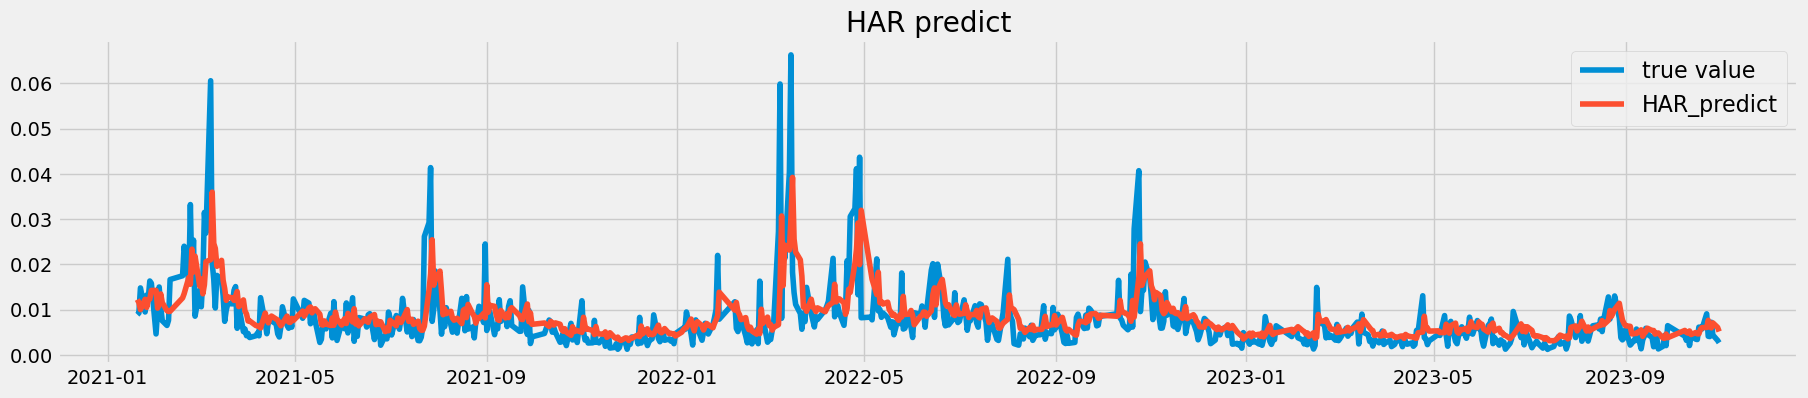

In [21]:
plt.figure(figsize=(20, 4))

plt.plot(y_vali,label = 'true value')
plt.plot(y_hat,label = 'HAR_predict' )
plt.plot()
plt.title('HAR predict', fontsize=20)
plt.legend(fontsize=16)
plt.show()

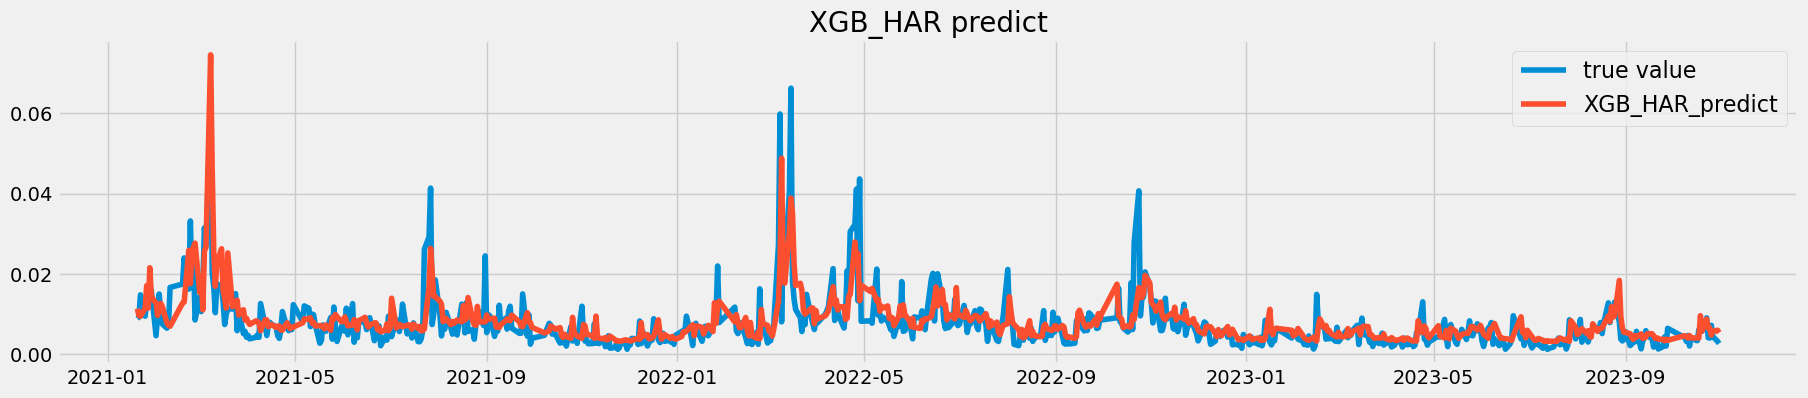

In [22]:
plt.figure(figsize=(20, 4))

plt.plot(y_vali,label = 'true value')
plt.plot(xgb_vali,label = 'XGB_HAR_predict' )
plt.plot()
plt.title('XGB_HAR predict', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [23]:
def indicator_function(diff_x, diff_x_hat):
    # 示性函数，当乘积大于等于0时返回1，否则返回0
    return np.where((diff_x * diff_x_hat) >= 0, 1, 0)

def calculate_DS(x, x_hat):
    n = len(x)
    DS = 0
    for i in range(n - 1):
        diff_x = x[i + 1] - x[i]
        diff_x_hat = x_hat[i + 1] - x[i]
        DS += diff_x * diff_x_hat * indicator_function(diff_x, diff_x_hat)
    DS /= (n - 1)
    return DS

In [24]:
# 计算MAE
MAE = mean_absolute_error(y_hat, y_vali)
# 计算MSE
RMSE = mean_squared_error(y_hat, y_vali)**0.5
# 计算QLIKE
MSLE = mean_squared_log_error(y_hat, y_vali)
# 计算R2LOG
R2 = r2_score(y_vali, y_hat)
# MAPE
MAPE = mean_absolute_percentage_error(y_hat, y_vali)

qlike = calculate_qlike(y_hat, y_vali)

DS_score = calculate_DS(y_vali, y_hat)
# 将结果以表格形式展示
import pandas as pd
metrics_table = pd.DataFrame({
    'Metric': ['MAE', 'MAPE', 'RMSE','MSLE','QLIKE','DS_score'],
    'Value_init': [MAE, MAPE, RMSE, MSLE, qlike,DS_score],
})

print(metrics_table)

     Metric  Value_init
0       MAE    0.003363
1      MAPE    0.384574
2      RMSE    0.005539
3      MSLE    0.000029
4     QLIKE   -3.999190
5  DS_score    0.000014


In [25]:
# 计算MAE
MAE = mean_absolute_error(xgb_vali, y_vali)
# 计算MSE
RMSE = mean_squared_error(xgb_vali, y_vali)**0.5
# 计算QLIKE
MSLE = mean_squared_log_error(xgb_vali, y_vali)
# 计算R2LOG
R2 = r2_score(xgb_vali, y_vali)
# MAPE
MAPE = mean_absolute_percentage_error(xgb_vali, y_vali)

qlike = calculate_qlike(xgb_vali, y_vali)

ds_score = calculate_DS(xgb_vali, y_vali)
# 将结果以表格形式展示
import pandas as pd
metrics_table = pd.DataFrame({
    'Metric': ['MAE', 'MAPE', 'RMSE','MSLE','qlike','ds_score'],
    'Value_init': [MAE, MAPE, RMSE, MSLE,qlike, ds_score],
})

print(metrics_table)

     Metric  Value_init
0       MAE    0.003083
1      MAPE    0.365449
2      RMSE    0.005078
3      MSLE    0.000025
4     qlike   -4.011792
5  ds_score    0.000015


# 6. test

## 6.1 data

In [26]:
test_raw = pd.read_csv("rv_5min/zdata/23_24.csv")
test = test_raw.copy()
test = test[['date', 'close','turnoverrate','flucamount','amplitude','RSI','M12','rv','rv_w','rv_m','SD','ATR']]
# 加一个copy不影响原表
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
test['returns'] = 100 * test.close.pct_change().dropna()
# 计算对数收益率
test['log_returns'] = np.log(test.close/test.close.shift(1))
# 删除缺失值和第一个NaN
test['log_returns'] = test['log_returns'].dropna()
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
test['rv_future'] = test['rv'].shift(-1)
test.dropna(inplace=True)

test.head(5)

,date,close,turnoverrate,flucamount,amplitude,RSI,M12,rv,rv_w,rv_m,SD,ATR,returns,log_returns,rv_future
21,2023-11-30,3496.20,0.3309,7.90,0.68,30.798350,-0.023969,0.003747,0.003017,0.002931,41.061365,33.660714,0.226184,0.002259,0.005583
22,2023-12-01,3482.88,0.3543,-13.32,1.20,30.002072,-0.034478,0.005583,0.003697,0.003061,45.091761,34.190000,-0.380985,-0.003817,0.002987
23,2023-12-04,3460.14,0.3172,-22.74,0.82,26.682987,-0.031413,0.002987,0.003648,0.003064,47.611832,33.993571,-0.652908,-0.006550,0.005313
24,2023-12-05,3394.26,0.3280,-65.88,1.63,14.751928,-0.048713,0.005313,0.004013,0.003128,57.188943,35.978571,-1.903969,-0.019223,0.005495
25,2023-12-06,3399.60,0.3454,5.34,1.10,18.310221,-0.049414,0.005495,0.004625,0.003174,63.292407,36.152857,0.157324,0.001572,0.004765


In [27]:
# 将 "Date" 列转换为日期格式
test['date'] = pd.to_datetime(test['date'])
test.index = test['date']
# 显示转换后的 DataFrame
test.head()

,date,close,turnoverrate,flucamount,amplitude,RSI,M12,rv,rv_w,rv_m,SD,ATR,returns,log_returns,rv_future
date,,,,,,,,,,,,,,,
2023-11-30,2023-11-30,3496.20,0.3309,7.90,0.68,30.798350,-0.023969,0.003747,0.003017,0.002931,41.061365,33.660714,0.226184,0.002259,0.005583
2023-12-01,2023-12-01,3482.88,0.3543,-13.32,1.20,30.002072,-0.034478,0.005583,0.003697,0.003061,45.091761,34.190000,-0.380985,-0.003817,0.002987
2023-12-04,2023-12-04,3460.14,0.3172,-22.74,0.82,26.682987,-0.031413,0.002987,0.003648,0.003064,47.611832,33.993571,-0.652908,-0.006550,0.005313
2023-12-05,2023-12-05,3394.26,0.3280,-65.88,1.63,14.751928,-0.048713,0.005313,0.004013,0.003128,57.188943,35.978571,-1.903969,-0.019223,0.005495
2023-12-06,2023-12-06,3399.60,0.3454,5.34,1.10,18.310221,-0.049414,0.005495,0.004625,0.003174,63.292407,36.152857,0.157324,0.001572,0.004765


In [28]:
print("测试集大小:", test.index)

# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
#y_train = train_['rv_future']
#y_vali = vali_['rv_future']
y_test = test['rv_future']


# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
#x_train = train_[['rv','rv_w','rv_m']]
#x_vali = vali_[['rv','rv_w','rv_m']]
x_test = test[['rv','rv_w','rv_m']]

测试集大小: DatetimeIndex(['2023-11-30', '2023-12-01', '2023-12-04', '2023-12-05',
               '2023-12-06', '2023-12-07', '2023-12-08', '2023-12-11',
               '2023-12-12', '2023-12-13',
               ...
               '2024-08-16', '2024-08-19', '2024-08-20', '2024-08-21',
               '2024-08-22', '2024-08-23', '2024-08-26', '2024-08-27',
               '2024-08-28', '2024-08-29'],
              dtype='datetime64[ns]', name='date', length=183, freq=None)


## 6.2 har

In [29]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(test["rv"].values)[1])
print("p-value for weekly RV:",adf(test["rv_w"].dropna().values)[1])
print("p-value for monthly RV:",adf(test["rv_m"].dropna().values)[1])

p-value for daily RV: 0.1834550277119275
p-value for weekly RV: 0.16681375102100038
p-value for monthly RV: 0.20918019151944411


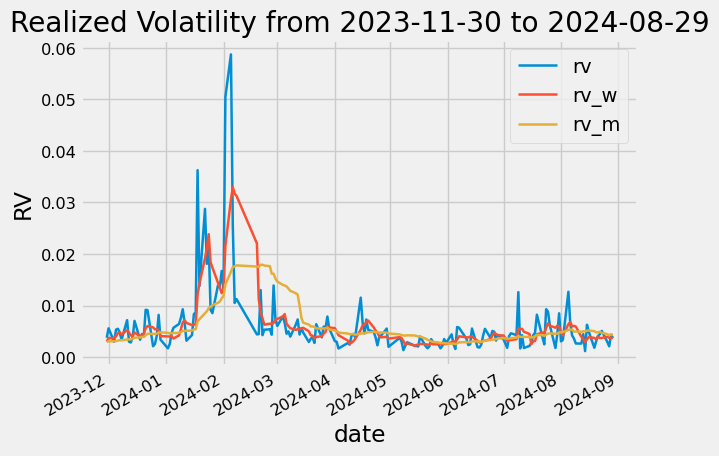

In [30]:
# Plot the RV variables.
test[['rv','rv_w','rv_m']].plot(title=f"Realized Volatility from {test.index.date[0]} to {test.index.date[-1]}", fontsize='small', linewidth=1.8)
plt.ylabel("RV")
plt.show()

In [31]:
x_test = sm.add_constant(x_test)
y_test_hat = ols_result.predict(x_test)
y_test_hat

date
2023-11-30    0.004430
2023-12-01    0.005330
2023-12-04    0.004514
2023-12-05    0.005407
2023-12-06    0.005760
                ...   
2024-08-23    0.005353
2024-08-26    0.004771
2024-08-27    0.004401
2024-08-28    0.005129
2024-08-29    0.004843
Length: 183, dtype: float64

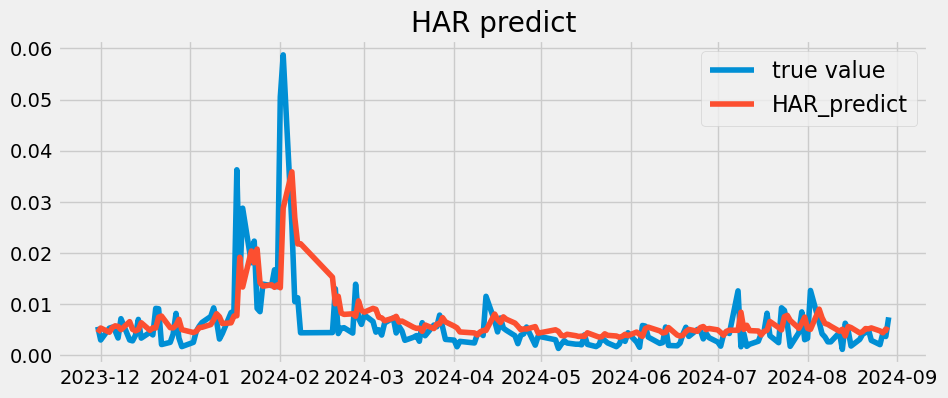

In [32]:
plt.figure(figsize=(10, 4))

plt.plot(y_test,label = 'true value')
plt.plot(y_test_hat,label = 'HAR_predict' )
plt.plot()
plt.title('HAR predict', fontsize=20)
plt.legend(fontsize=16)
plt.show()

In [33]:
def huber_loss(y_true, y_pred):
    """
    计算 Huber Loss
    :param y_true: 真实值
    :param y_pred: 预测值
    :param delta: 阈值参数
    :return: Huber Loss 的值
    """
    delta = 1
    errors = y_true - y_pred
    is_small_error = np.abs(errors) <= delta
    small_error_loss = 0.5 * np.square(errors)
    large_error_loss = delta * np.abs(errors) - 0.5 * delta**2
    return np.where(is_small_error, small_error_loss, large_error_loss).mean()

In [34]:
# 计算MAE
MAE = mean_absolute_error(y_test_hat,y_test)
# 计算MSE
RMSE = mean_squared_error(y_test_hat,y_test)**0.5
# 计算QLIKE
MSLE = mean_squared_log_error(y_test_hat,y_test)
# 计算R2LOG
R2 = r2_score(y_test,y_test_hat)
# MAPE
MAPE = mean_absolute_percentage_error(y_test_hat,y_test)

qlike = calculate_qlike(y_test_hat,y_test)

DS_score = calculate_DS(y_test_hat,y_test)

huber = huber_loss(y_test, y_test_hat)
# 将结果以表格形式展示
import pandas as pd
metrics_table = pd.DataFrame({
    'Metric': ['MAE', 'MAPE', 'RMSE','MSLE','QLIKE','DS_score','R2','huber'],
    'Value_init': [MAE, MAPE, RMSE, MSLE, qlike,DS_score,R2,huber],
})

print(metrics_table)

     Metric  Value_init
0       MAE    0.003026
1      MAPE    0.405228
2      RMSE    0.005519
3      MSLE    0.000029
4     QLIKE   -4.236855
5  DS_score    0.000009
6        R2    0.360598
7     huber    0.000015


# 6.3 XGB

In [35]:
x_xgb3 = pd.DataFrame()  
y_xgb3 = y_test.copy()

x_xgb3['har'] = y_test_hat
x_xgb3['past_1'] = test['rv']
x_xgb3['past_2'] = test['rv'].shift(1)
x_xgb3['past_w'] = test['rv_w']
x_xgb3['past_m'] = test['rv_m']
x_xgb3['close'] = test['close']
x_xgb3['returns'] = test['returns']
#x_xgb3['turn'] = test['turnoverrate']
#x_xgb3['flucamount'] = test['flucamount']
x_xgb3['ampli'] = test['amplitude']
x_xgb3['rsi'] = test['RSI']
x_xgb3['m12'] = test['M12']
#x_xgb3['uperband'] = test['Upper_band']
#x_xgb3['lowerband'] = test['Lower_Band']
#x_xgb3['sma'] = test['SMA']
#x_xgb3['sd'] = test['SD']
#x_xgb3['atr'] = test['ATR']

x_xgb3 = pd.DataFrame(x_xgb3, index = y_test.index)

#xgb_test = xgb_har_ti_ta.predict(x_xgb3)
xgb_test = xgb_har_ti_ta.predict(x_xgb3)
xgb_test = pd.Series(xgb_test, index = y_test.index)

In [36]:
# 计算MAE
MAE = mean_absolute_error(xgb_test, y_test)
# 计算MSE
RMSE = mean_squared_error(xgb_test, y_test)**0.5
# 计算QLIKE
MSLE = mean_squared_log_error(xgb_test, y_test)
# 计算R2LOG
R2 = r2_score(y_test,xgb_test)
# MAPE
MAPE = mean_absolute_percentage_error(xgb_test, y_test)
huber = huber_loss(y_test, xgb_test)
qlike = calculate_qlike(xgb_test, y_test)

ds_score = calculate_DS(xgb_test, y_test)
# 将结果以表格形式展示
import pandas as pd
metrics_table = pd.DataFrame({
    'Metric': ['MAE', 'MAPE', 'RMSE','MSLE','qlike','ds_score','R2','huber'],
    'Value_init': [MAE, MAPE, RMSE, MSLE,qlike, ds_score,R2,huber],
})

print(metrics_table)

     Metric  Value_init
0       MAE    0.002852
1      MAPE    0.409496
2      RMSE    0.005449
3      MSLE    0.000028
4     qlike   -4.251522
5  ds_score    0.000006
6        R2    0.376802
7     huber    0.000015


In [ ]:
'''
     Metric  Value_init
0       MAE    0.002852
1      MAPE    0.409496
2      RMSE    0.005449
3      MSLE    0.000028
4     qlike   -4.251522
5  ds_score    0.000006
6        R2    0.376802
7     huber    0.000015

x_xgb3['har'] = y_test_hat
x_xgb3['past_1'] = test['rv']
x_xgb3['past_2'] = test['rv'].shift(1)
x_xgb3['past_w'] = test['rv_w']
x_xgb3['past_m'] = test['rv_m']
x_xgb3['close'] = test['close']
x_xgb3['returns'] = test['returns']
#x_xgb3['turn'] = test['turnoverrate']
#x_xgb3['flucamount'] = test['flucamount']
x_xgb3['ampli'] = test['amplitude']
x_xgb3['rsi'] = test['RSI']
x_xgb3['m12'] = test['M12']
#x_xgb3['uperband'] = test['Upper_band']
#x_xgb3['lowerband'] = test['Lower_Band']
#x_xgb3['sma'] = test['SMA']
#x_xgb3['sd'] = test['SD']
#x_xgb3['atr'] = test['ATR']

pbounds = {
    'max_depth': (6, 12),  # 树的最大深度
    'learning_rate': (0.05, 0.09),  # 学习率
    'subsample': (0.7, 1),  # 训练时用到的样本比例
    'reg_lambda':(5,10),
    'alpha':(0,0.1)
}

# 运行优化
optimizer.maximize(init_points=110, n_iter=110)
'''

In [37]:
'''

     Metric  Value_init
0       MAE    0.002857
1      MAPE    0.410435
2      RMSE    0.005413
3      MSLE    0.000028
4     qlike   -4.249309
5  ds_score    0.000006

x_xgb3['har'] = y_test_hat
x_xgb3['past_1'] = test['rv']
x_xgb3['past_w'] = test['rv_w']
x_xgb3['past_m'] = test['rv_m']
x_xgb3['close'] = test['close']
x_xgb3['returns'] = test['returns']
#x_xgb3['turn'] = test['turnoverrate']
#x_xgb3['flucamount'] = test['flucamount']
x_xgb3['ampli'] = test['amplitude']
x_xgb3['rsi'] = test['RSI']
x_xgb3['m12'] = test['M12']
#x_xgb3['uperband'] = test['Upper_band']
#x_xgb3['lowerband'] = test['Lower_Band']
#x_xgb3['sma'] = test['SMA']
#x_xgb3['sd'] = test['SD']
#x_xgb3['atr'] = test['ATR']

pbounds = {
    'max_depth': (6, 9),  # 树的最大深度
    'learning_rate': (0.05, 0.09),  # 学习率
    'subsample': (0.7, 1),  # 训练时用到的样本比例
    'reg_lambda':(5,10),
    'alpha':(0,0.1)
}

optimizer.maximize(init_points=110, n_iter=110)
'''

"\n\n     Metric  Value_init\n0       MAE    0.002857\n1      MAPE    0.410435\n2      RMSE    0.005413\n3      MSLE    0.000028\n4     qlike   -4.249309\n5  ds_score    0.000006\n\nx_xgb3['har'] = y_test_hat\nx_xgb3['past_1'] = test['rv']\nx_xgb3['past_w'] = test['rv_w']\nx_xgb3['past_m'] = test['rv_m']\nx_xgb3['close'] = test['close']\nx_xgb3['returns'] = test['returns']\n#x_xgb3['turn'] = test['turnoverrate']\n#x_xgb3['flucamount'] = test['flucamount']\nx_xgb3['ampli'] = test['amplitude']\nx_xgb3['rsi'] = test['RSI']\nx_xgb3['m12'] = test['M12']\n#x_xgb3['uperband'] = test['Upper_band']\n#x_xgb3['lowerband'] = test['Lower_Band']\n#x_xgb3['sma'] = test['SMA']\n#x_xgb3['sd'] = test['SD']\n#x_xgb3['atr'] = test['ATR']\n\npbounds = {\n    'max_depth': (6, 9),  # 树的最大深度\n    'learning_rate': (0.05, 0.09),  # 学习率\n    'subsample': (0.7, 1),  # 训练时用到的样本比例\n    'reg_lambda':(5,10),\n    'alpha':(0,0.1)\n}\n\noptimizer.maximize(init_points=110, n_iter=110)\n"

In [38]:
'''
    Metric  Value_init
0       MAE    0.002833
1      MAPE    0.420713
2      RMSE    0.005484
3      MSLE    0.000029
4     qlike   -4.251751
5  ds_score    0.000006

x_xgb2['har'] = y_hat
x_xgb2['past_1'] = df['rv'][split1:]
x_xgb2['past_w'] = df['rv_w'][split1:]
x_xgb2['past_m'] = df['rv_m'][split1:]
x_xgb2['close'] = df['close'][split1:]
x_xgb2['returns'] = df['returns'][split1:]
#x_xgb2['turn'] = df['turnoverrate'][split1:]
x_xgb2['flucamount'] = df['flucamount'][split1:]
x_xgb2['ampli'] = df['amplitude'][split1:]
x_xgb2['rsi'] = rsi[split1:]
x_xgb2['m12'] = m12[split1:]
#x_xgb2['uperband'] = upperband[split1:]
#x_xgb2['lowerband'] = lowerband[split1:]
#x_xgb2['sma'] = sma[split1:]
#x_xgb2['sd'] = sd[split1:]
#x_xgb2['atr'] = atr[split1:]

# 定义超参数搜索空间
pbounds = {
    'max_depth': (6, 9),  # 树的最大深度
    'learning_rate': (0.05, 0.09),  # 学习率
    'subsample': (0.8, 1),  # 训练时用到的样本比例
    'reg_lambda':(5,11),
    'alpha':(0,0.1)
}

optimizer.maximize(init_points=110, n_iter=110)

'''

"\n    Metric  Value_init\n0       MAE    0.002833\n1      MAPE    0.420713\n2      RMSE    0.005484\n3      MSLE    0.000029\n4     qlike   -4.251751\n5  ds_score    0.000006\n\nx_xgb2['har'] = y_hat\nx_xgb2['past_1'] = df['rv'][split1:]\nx_xgb2['past_w'] = df['rv_w'][split1:]\nx_xgb2['past_m'] = df['rv_m'][split1:]\nx_xgb2['close'] = df['close'][split1:]\nx_xgb2['returns'] = df['returns'][split1:]\n#x_xgb2['turn'] = df['turnoverrate'][split1:]\nx_xgb2['flucamount'] = df['flucamount'][split1:]\nx_xgb2['ampli'] = df['amplitude'][split1:]\nx_xgb2['rsi'] = rsi[split1:]\nx_xgb2['m12'] = m12[split1:]\n#x_xgb2['uperband'] = upperband[split1:]\n#x_xgb2['lowerband'] = lowerband[split1:]\n#x_xgb2['sma'] = sma[split1:]\n#x_xgb2['sd'] = sd[split1:]\n#x_xgb2['atr'] = atr[split1:]\n\n# 定义超参数搜索空间\npbounds = {\n    'max_depth': (6, 9),  # 树的最大深度\n    'learning_rate': (0.05, 0.09),  # 学习率\n    'subsample': (0.8, 1),  # 训练时用到的样本比例\n    'reg_lambda':(5,11),\n    'alpha':(0,0.1)\n}\n\noptimizer.maximize

     Metric  Value_init
0       MAE    0.002857
1      MAPE    0.410435
2      RMSE    0.005413
3      MSLE    0.000028
4     qlike   -4.249309
5  ds_score    0.000006

     Metric  Value_init
0       MAE    0.003087
1      MAPE    0.411352
2      RMSE    0.005538
3      MSLE    0.000029
4     qlike   -4.236956
5  ds_score    0.000007

    Metric  Value_init
0       MAE    0.003067
1      MAPE    0.414270
2      RMSE    0.005659
3      MSLE    0.000031
4     qlike   -4.237162
5  ds_score    0.000006